In [1]:
import numpy as np
from scipy.optimize import nnls
from matplotlib import pyplot as plt

Our goal is to optimize the function $||AB - X||_F^2 + \lambda^2||Av-y||^2$ where $A,B$ are constrained to be non-negative while $v$ is not.

In [2]:
def matrix_nnls(A,X):
    
    '''Returns the non-negative matrix B which minimizes ||AB - X||^2'''
    
    m,k = A.shape
    m_,n = X.shape
    
    if m != m_:
        raise ValueError('First dimensions on inputs must match')
       
    X_cols = [X[:,i] for i in range(0,n)]
    nnls_by_col = [nnls(A, col)[0] for col in X_cols]
    return np.column_stack(nnls_by_col)

In [3]:
def do_training(X, y_vec, lmda, k, num_iters=100, return_loss_list = False):
    
    '''Iteratively minimizes $||AB - X||_F^2 + \lambda^2||Av-y||^2$ where X and y are given, with A having k columns and B having
    k rows. A and B are constrained to be non-negative.  v is not.'''
        
    m,n = X.shape
    y = y_vec.reshape((m,1))

    
    #random initializations
    A = np.random.normal(size=(m,k))
    B = np.random.normal(size=(k,n))
    v = np.random.normal(size=(k,1))
    
    def objective(A,B,v):
        return np.linalg.norm(A @ B - X)**2 + (lmda**2) * np.linalg.norm(A@v - y)**2
    
    loss_list = []
    
    for i in range(0,num_iters):
        
        loss_list.append(objective(A,B,v))
        
        B = matrix_nnls(A,X)
        
        v = np.linalg.lstsq(A,y,rcond=None)[0]
        
        A = np.transpose(matrix_nnls( 
            np.transpose(np.concatenate( (B, lmda*v),axis=1) ), 
            np.transpose(np.concatenate( (X, lmda*y),axis=1) )))
    
    final_loss = objective(A,B,v)
    loss_list.append(final_loss)
    
    if return_loss_list:
        return (A,B,v), loss_list
    else:
        return (A,B,v), final_loss

<b>Example</b>

In [4]:
X = np.array([[1,2,3],[4,5,6],[7,8,9]])
y = np.array([2,1,1])

In [5]:
do_training(X,y,lmda=1, k=2, num_iters=100)

((array([[0., 0.],
         [0., 0.],
         [0., 0.]]),
  array([[0., 0., 0.],
         [0., 0., 0.]]),
  array([[0.],
         [0.]])),
 291.00000000000006)

<b>Generating synthetic data</b>

In [6]:
def perfectly_reconstructible(m,n,k):
    
    '''Constructs a perfectly reconstructible ensemble with rank k factorization.  X has dimensions mxn.'''
    A = np.abs(np.random.normal(size = (m,k)))
    B = np.abs(np.random.normal(size = (k,n)))
    v = np.random.normal(size = (k,1))
    
    X = A @ B
    y = A @ v
    
    return (X,y), (A,B,v)

In [7]:
def noisy_problem(m,n,k, noise_rate=1):
    '''Adds random positive noise to X. noise is the norm of the noise vector.'''
    (X,y), (A,B,v) = perfectly_reconstructible(m,n,k)
    
    noise = np.abs(np.random.normal(size=(m,n)))
    noise = noise_rate*(noise/np.linalg.norm(noise))
    
    X = X + noise
    return (X,y), (A,B,v)

<b>Testing on synthetic data</b>

In [11]:
(X,y), (A,B,v) = perfectly_reconstructible(100,100,k=2)
(A_, B_, v_), objective_val = do_training(X, y, lmda=1, k=2, num_iters=100)

A_err = np.linalg.norm(A - A_) / np.linalg.norm(A)
B_err = np.linalg.norm(B - B_) / np.linalg.norm(B)
v_err = np.linalg.norm(v - v_) / np.linalg.norm(v)

print("Relative reconstruction errors:")
print("A: ", A_err, "\nB: ", B_err, "\nv: ", v_err)

print("Final value of objective: ", objective_val)

Relative reconstruction errors:
A:  4.879477597572684 
B:  0.8207988894243886 
v:  0.8502616512659302
Final value of objective:  0.00934708062771773


---
How does $\lambda$ effect the convergence behavior of our method?

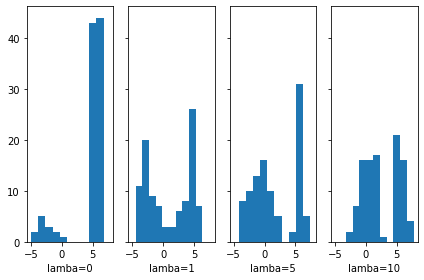

In [18]:
trials = 100
iters = 100
m,n,k = 50,50,5
lmdas = [0,1,5,10]

(X,y), (A,B,v) = noisy_problem(m,n,k, noise_rate=0.1)

data_by_lambda =  [ [do_training(X, y, lmda=lmda, k=k, num_iters=iters)[-1] for i in range(0,trials)] for lmda in lmdas]

fig, axs = plt.subplots(1, len(lmdas), sharey=True, sharex=True, tight_layout=True)

for i,data in enumerate(data_by_lambda):
    axs[i].hist(np.log(data), bins=10)
    axs[i].set_xlabel("lamba="+str(lmdas[i]))

plt.show()

---
What does the convergence behavior look like on individual iterations? (For a fixed system.)

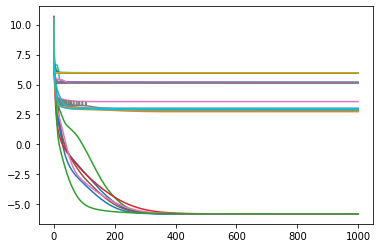

In [206]:
m,n,k = 50,50,5
lmda = 1
(X,y), (A,B,v) = noisy_problem(m,n,k, noise_rate=0.1)

for i in range(0,30):
    losses = do_training(X, y, lmda=1, k=k, num_iters=1000, return_loss_list=True)[-1]
    plt.plot(np.log(losses))

plt.show()

Here we plot the log loss as a function of the iteration number for various random initializations.

In [13]:
L = [1,2,3]

In [14]:
for e in enumerate(L):
    print(e)

(0, 1)
(1, 2)
(2, 3)
